# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import glob

%matplotlib inline

In [2]:
dataset = get_dataset("processed_data/processed/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['processed_data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['processed_data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [3]:
feature_description = {
    "image/height": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "image/width": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "image/filename": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "image/source_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "image/encoded": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "image/format": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
    "image/object/class/text": tf.io.VarLenFeature(tf.string),
    "image/object/class/label": tf.io.VarLenFeature(tf.int64),
}


def parse_dataset(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

In [4]:
filenames = glob.glob("processed_data/processed/*.tfrecord")
unprocessed_dataset = tf.data.TFRecordDataset(filenames).map(parse_dataset)

In [5]:
print("Processed dataset-")
display(dataset)

print("Unprocessed dataset-")
display(unprocessed_dataset)

Processed dataset-


<DatasetV1Adapter shapes: {image: (None, None, 3), source_id: (), key: (), filename: (), groundtruth_image_confidences: (None,), groundtruth_verified_neg_classes: (None,), groundtruth_not_exhaustive_classes: (None,), groundtruth_boxes: (None, 4), groundtruth_area: (None,), groundtruth_is_crowd: (None,), groundtruth_difficult: (None,), groundtruth_group_of: (None,), groundtruth_weights: (None,), groundtruth_classes: (None,), groundtruth_image_classes: (None,), original_image_spatial_shape: (2,)}, types: {image: tf.uint8, source_id: tf.string, key: tf.string, filename: tf.string, groundtruth_image_confidences: tf.float32, groundtruth_verified_neg_classes: tf.int64, groundtruth_not_exhaustive_classes: tf.int64, groundtruth_boxes: tf.float32, groundtruth_area: tf.float32, groundtruth_is_crowd: tf.bool, groundtruth_difficult: tf.int64, groundtruth_group_of: tf.bool, groundtruth_weights: tf.float32, groundtruth_classes: tf.int64, groundtruth_image_classes: tf.int64, original_image_spatial_sh

Unprocessed dataset-


<MapDataset shapes: {image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/object/class/label: (None,), image/object/class/text: (None,), image/encoded: (), image/filename: (), image/format: (), image/height: (), image/source_id: (), image/width: ()}, types: {image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/object/class/text: tf.string, image/encoded: tf.string, image/filename: tf.string, image/format: tf.string, image/height: tf.int64, image/source_id: tf.string, image/width: tf.int64}>

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [6]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    color_mapping = {1: 'green', 2: 'red', 4: 'yellow'}
    
    px = 1/plt.rcParams['figure.dpi']
    
    original_width = batch["original_image_spatial_shape"].numpy()[0]
    original_height = batch["original_image_spatial_shape"].numpy()[1]

    groundtruth_boxes = batch["groundtruth_boxes"].numpy()
    groundtruth_image_classes = batch["groundtruth_classes"].numpy()
    
    image = batch["image"]

    fig, ax = plt.subplots(figsize=(original_width*px, original_height*px))
    ax.imshow(image)
    ax.axis("off")
    for box, label in zip(groundtruth_boxes, groundtruth_image_classes):
        xy = (box[3]*image.shape[1], box[2]*image.shape[0])
        height = (box[2] - box[0])*image.shape[0]
        width = (box[3] - box[1])*image.shape[1]
        cy = box[0]*image.shape[0]
        cx = box[1]*image.shape[1]
        rec = patches.Rectangle((cx, cy), width, height, linewidth=2, edgecolor=color_mapping[label], facecolor='none')
        ax.add_patch(rec)

In [7]:
def display_unprocessed_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    color_mapping = {1: 'green', 2: 'red', 4: 'yellow'}
    
    px = 1/plt.rcParams['figure.dpi']
    
    original_width = batch["image/width"].numpy()
    original_height = batch["image/height"].numpy()

    groundtruth_boxes_xmin = tf.sparse.to_dense(batch["image/object/bbox/xmin"]).numpy() * original_width 
    groundtruth_boxes_xmax = tf.sparse.to_dense(batch["image/object/bbox/xmax"]).numpy() * original_width
    groundtruth_boxes_ymin = tf.sparse.to_dense(batch["image/object/bbox/ymin"]).numpy() * original_height 
    groundtruth_boxes_ymax = tf.sparse.to_dense(batch["image/object/bbox/ymax"]).numpy() * original_height
    groundtruth_image_classes = tf.sparse.to_dense(batch["image/object/class/label"]).numpy() 
    
    groundtruth_boxes = zip(groundtruth_boxes_xmin, groundtruth_boxes_xmax, groundtruth_boxes_ymin, groundtruth_boxes_ymax)
    image = tf.io.decode_jpeg(batch["image/encoded"])

    fig, ax = plt.subplots(figsize=(original_width*px, original_height*px))
    ax.imshow(image)
    ax.axis("off")
    for box, label in zip(groundtruth_boxes, groundtruth_image_classes):
        width, height = box[1] - box[0], box[3] - box[2]
        rec = patches.Rectangle((box[0], box[2]), width, height, linewidth=2, edgecolor=color_mapping[label], facecolor='none')
        ax.add_patch(rec)

## Display 10 images 


Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

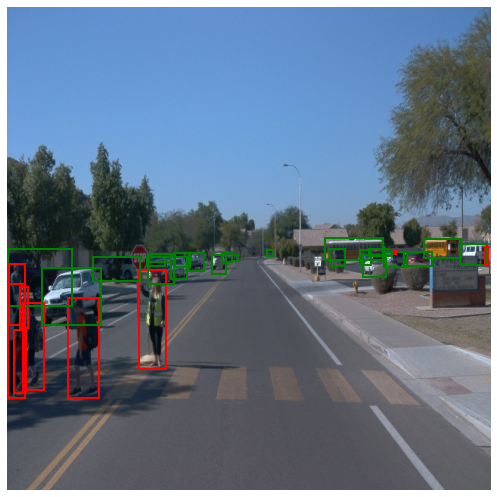

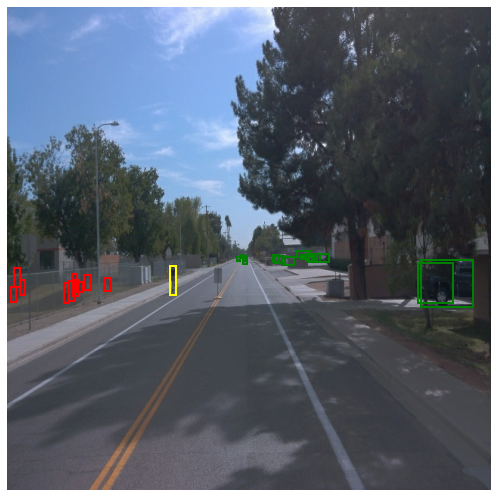

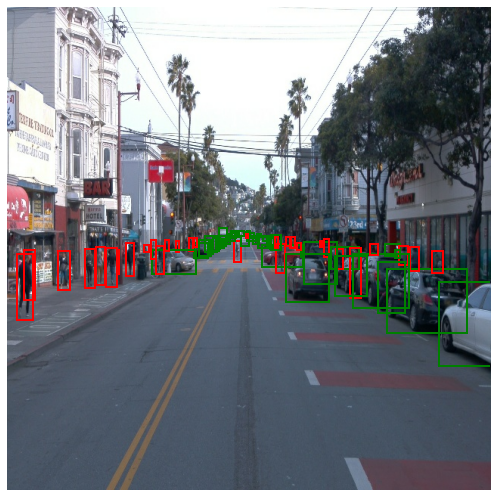

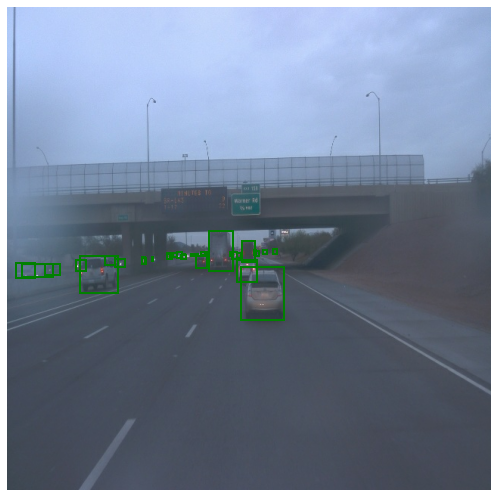

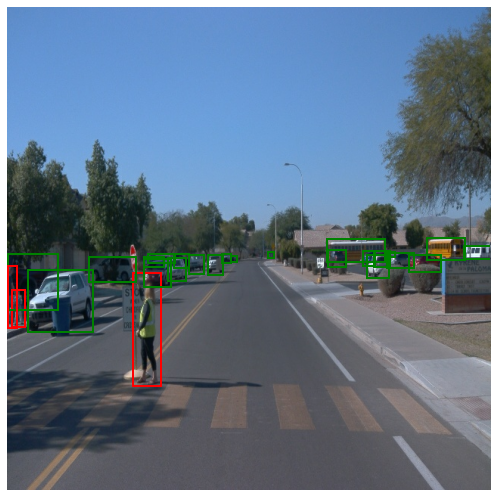

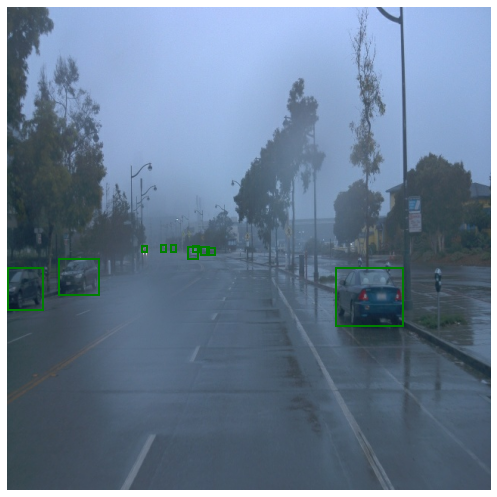

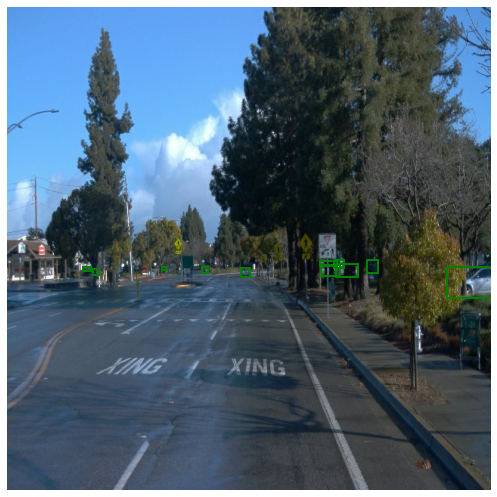

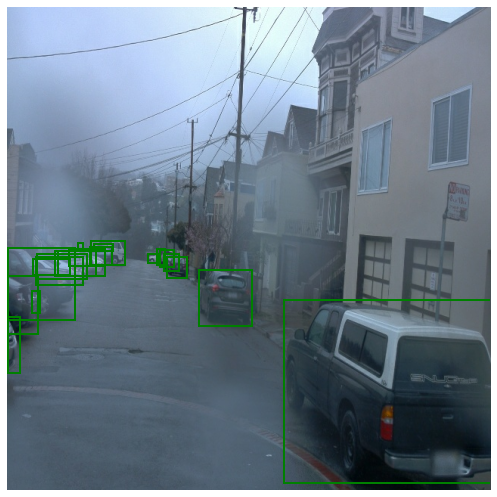

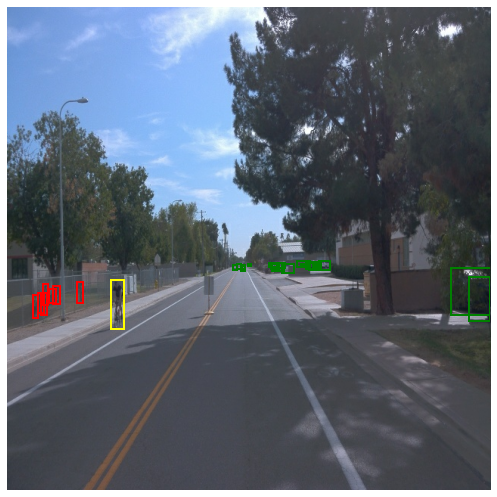

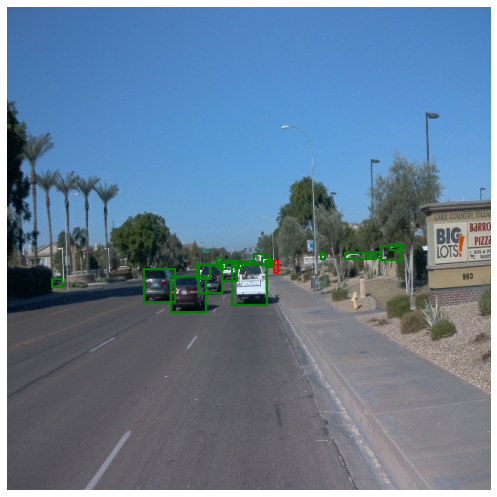

In [8]:
for batch in dataset.shuffle(2000, reshuffle_each_iteration=True).take(10):
    display_instances(batch)

In [9]:
entries_in_unprocessed_dataset = 0
for fn in unprocessed_dataset:
    entries_in_unprocessed_dataset += 1

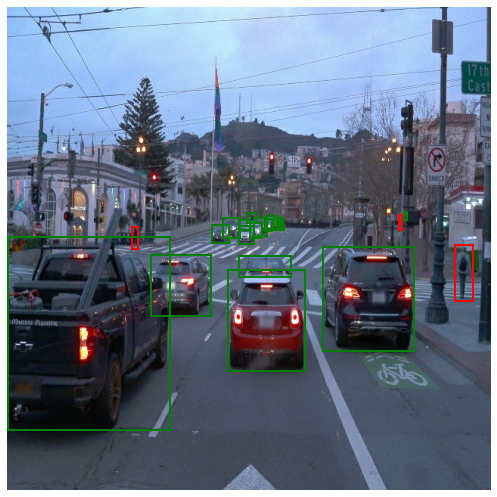

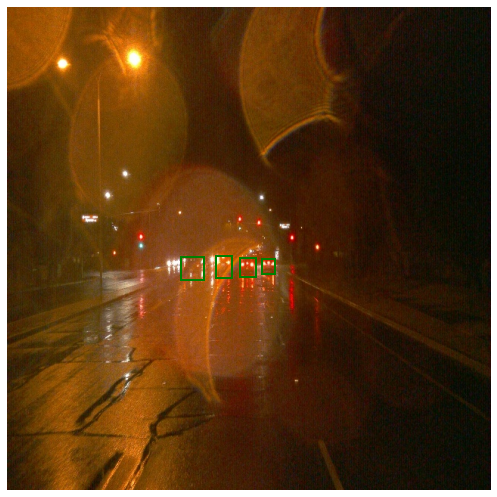

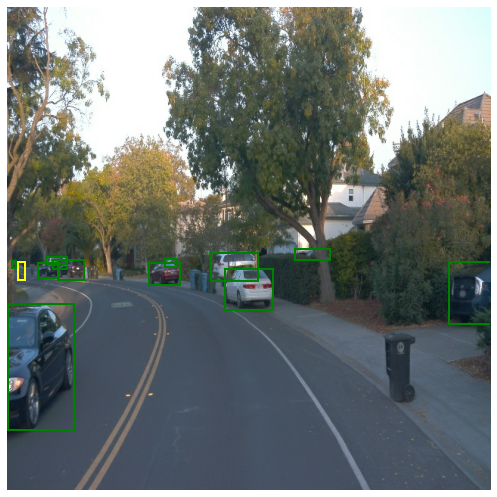

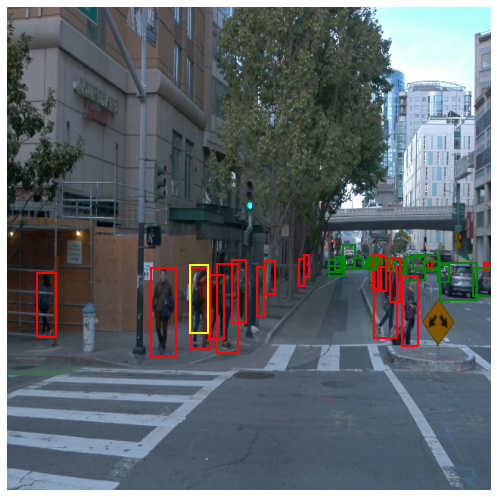

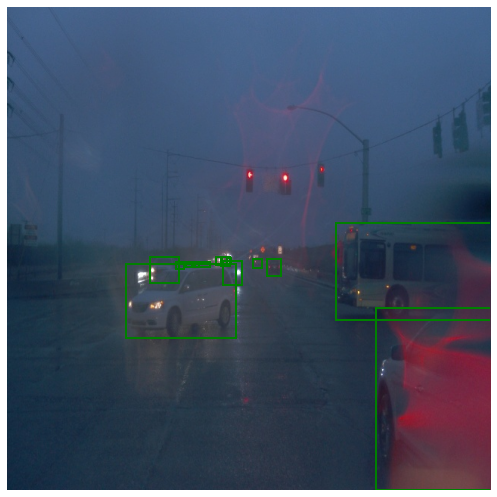

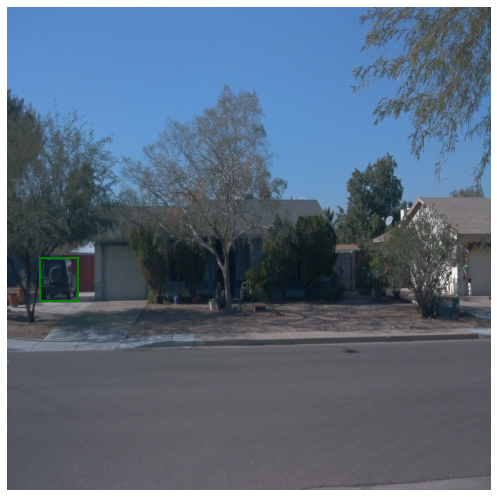

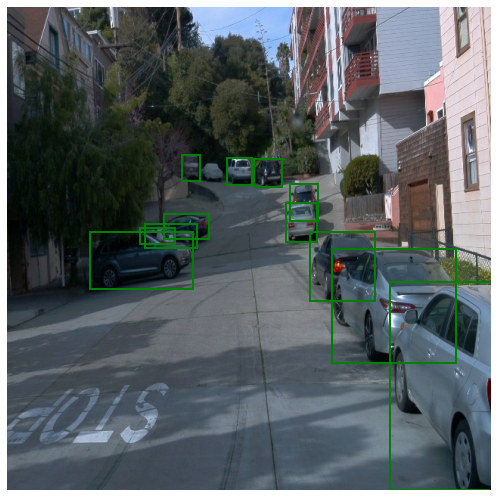

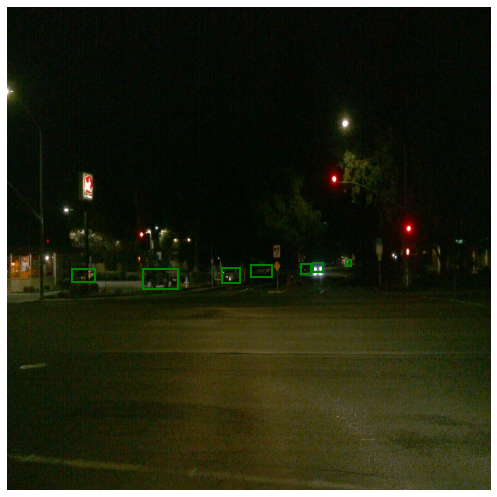

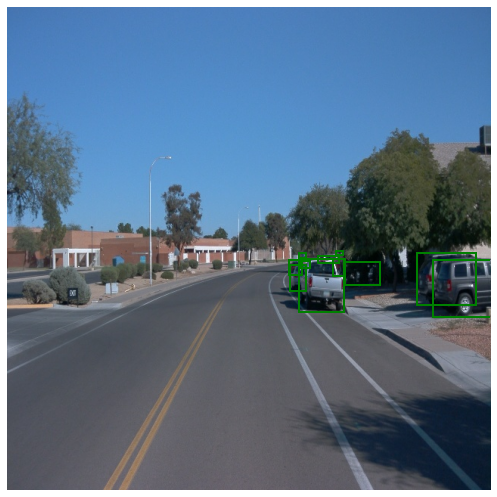

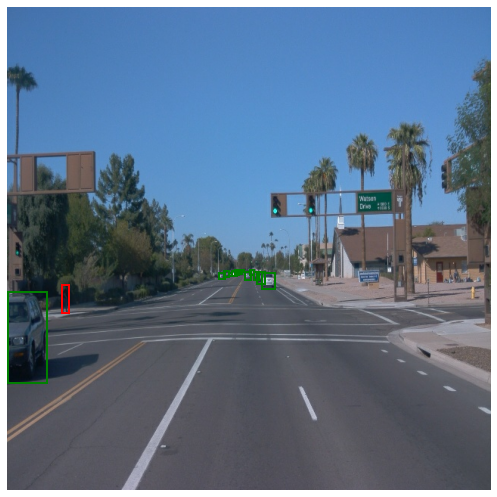

In [10]:
for batch in unprocessed_dataset.shuffle(entries_in_unprocessed_dataset, reshuffle_each_iteration=True).take(10):
    display_unprocessed_instances(batch)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [11]:
print(f"Number of entries in the dataset {entries_in_unprocessed_dataset}")

Number of entries in the dataset 19803
